In [1]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
engine = author.processed_engine

2015년부터 5년간 비트코인의 가격과 연관된 정보들을 가져온다.

gap은 그날의 (고가 - 종가) / 시초가 로 변동성을 확인 하기 위한 지표이다.</br>
나머지 지표들은 말 그대로를 의미한다.

In [4]:
df = pd.read_sql("SELECT * FROM QQQ_1d",engine) #로컬 db에서 테이블 가져옴
df.set_index(df.columns[0], inplace=True)
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d
time,,,,,,,,,
2015-01-22,98.112480,0.024597,60.043077,-0.399651,-0.248995,95.869239,40887200,-72.882684,-82.178683
2015-01-23,98.329391,0.008292,61.074968,-0.331890,-0.060847,96.000406,34783000,-103.268362,-89.219295
2015-01-26,98.216217,0.006949,60.201395,-0.249867,0.078227,96.066190,19960900,-103.329163,-93.927363
2015-01-27,95.669807,0.014441,44.706964,-0.203260,-0.016835,96.041193,45253200,-104.026624,-97.296062
2015-01-28,95.179390,0.022597,42.441376,-0.188657,-0.130244,95.991840,43591700,-109.590234,-101.395969
...,...,...,...,...,...,...,...,...,...
2022-04-01,361.850006,0.013999,57.197639,2.794090,5.560792,205.659233,54503500,6.197740,6.443430
2022-04-04,369.299988,0.018955,61.366975,3.452207,6.084675,205.767085,45950200,15.795502,9.560787
2022-04-05,361.100006,0.023921,55.014819,3.916096,5.771653,205.906741,62738700,3.363076,7.494884


In [5]:
df.describe()

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d
count,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1817.000000,1.817000e+03,1817.000000,1817.000000
mean,191.826587,0.014214,56.669050,0.968268,0.978263,130.855282,3.817175e+07,-41.407762,-41.516772
std,89.007399,0.011152,11.562127,2.610167,2.805442,29.865804,2.237694e+07,48.315220,46.470639
min,91.760803,0.002457,19.149513,-10.626321,-12.740338,95.869239,7.079300e+06,-268.397610,-225.040755
25%,113.648544,0.007458,48.521293,0.002121,-0.078913,102.434042,2.311470e+07,-73.416768,-77.224379
50%,166.405319,0.011035,57.530001,0.940156,0.965735,125.281372,3.161380e+07,-27.811063,-28.317033
75%,241.803757,0.017568,64.987573,2.222027,2.368400,148.953210,4.530740e+07,-2.659104,0.577213
max,402.981812,0.209936,85.587232,7.751603,9.257179,206.230479,1.986858e+08,54.615765,23.947386


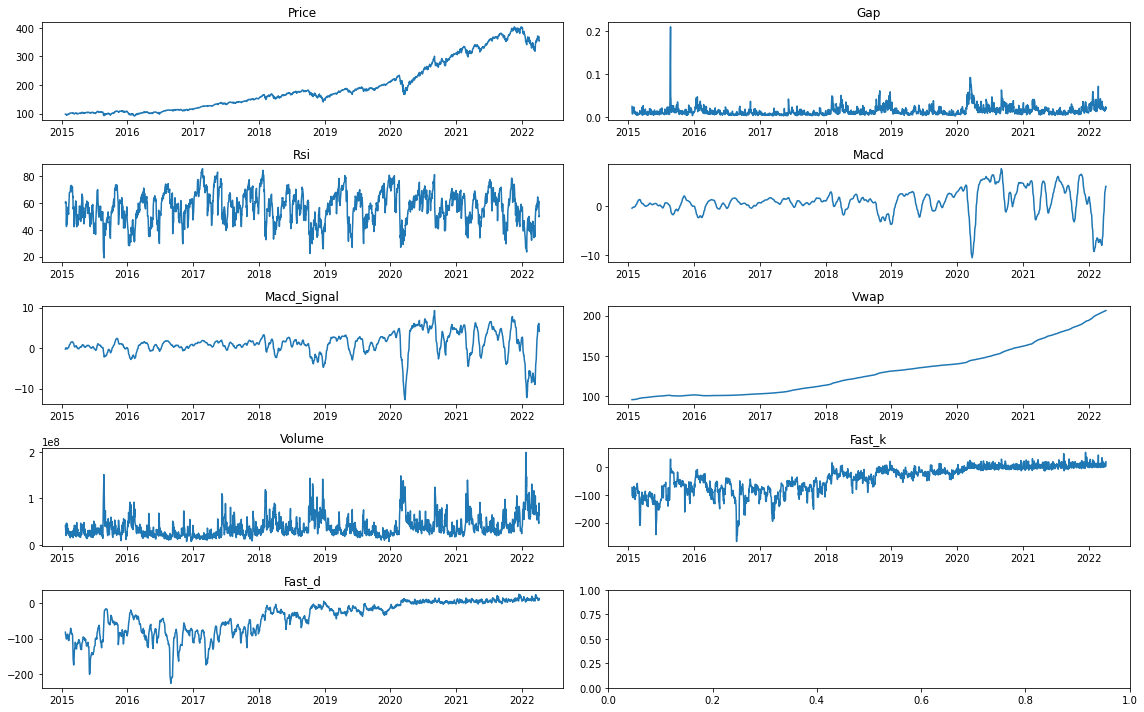

In [6]:
get_rows = lambda x: x // 2 if x % 2 == 0 else x // 2 +1 #행의 수를 결정한다.
rows = get_rows(len(df.columns))
fig, axes = plt.subplots(rows, 2, figsize=(16,10))
for i, c in enumerate(df.columns, start=1):
        plt.subplot(len(df.columns) // 2 + 1,2,i)
        plt.plot(df[c])
        plt.title(c)
plt.tight_layout()

volume은 시간이 지남에 따라 상승하는 경향이 보이므로 이동평균을 통해 나눠준 값을 사용한다.</br>
거래량 = 거래량 / 지난 7일간의 평균 거래량 평균적인 거래량에 비해 얼마나 더 많이 거래가 발생했는지 확인 가능하다.</br>
가격 역시 시간이 지남에 따라 자연히 증가하므로 전일 대비 증감률로 표현해준다.

이렇게 데이터를 변형해 줌으로써 모델은 가격이 시간이 지남에 따라 자연히 증가하는 것이 아니라 학습 할 수 있고 </br>
정확한 가격을 예측하는 것보다 수익률을 예측 함으로써 예측의 난이도를 낮출 수 있다고 기대된다.

In [7]:
volume_mva = df['Volume'].rolling(window = 7).mean()
df['Volume'] = df['Volume'] / volume_mva
df['Pct'] = df['Price'].pct_change()
df = df.apply(lambda x: x.round(3)) #적당히 값을 묶어주기 위해 소수점 3자리를 기점으로 반올림을 진행한다.
df = df.dropna() #결측치를 제거해준다.
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Pct
time,,,,,,,,,,
2015-01-30,95.349,0.016,44.179,-0.187,-0.214,95.965,1.097,-107.487,-97.350,-0.008
2015-02-02,96.179,0.023,48.785,-0.189,-0.199,95.975,1.104,-68.408,-87.702,0.009
2015-02-03,97.103,0.013,53.396,-0.174,-0.112,96.013,0.789,-87.676,-87.693,0.010
2015-02-04,97.018,0.012,52.925,-0.149,-0.049,96.049,0.832,-101.370,-92.252,-0.001
2015-02-05,97.858,0.009,56.970,-0.105,0.068,96.092,0.623,-96.018,-93.508,0.009
...,...,...,...,...,...,...,...,...,...,...
2022-04-01,361.850,0.014,57.198,2.794,5.561,205.659,0.895,6.198,6.443,-0.002
2022-04-04,369.300,0.019,61.367,3.452,6.085,205.767,0.768,15.796,9.561,0.021
2022-04-05,361.100,0.024,55.015,3.916,5.772,205.907,1.036,3.363,7.495,-0.022


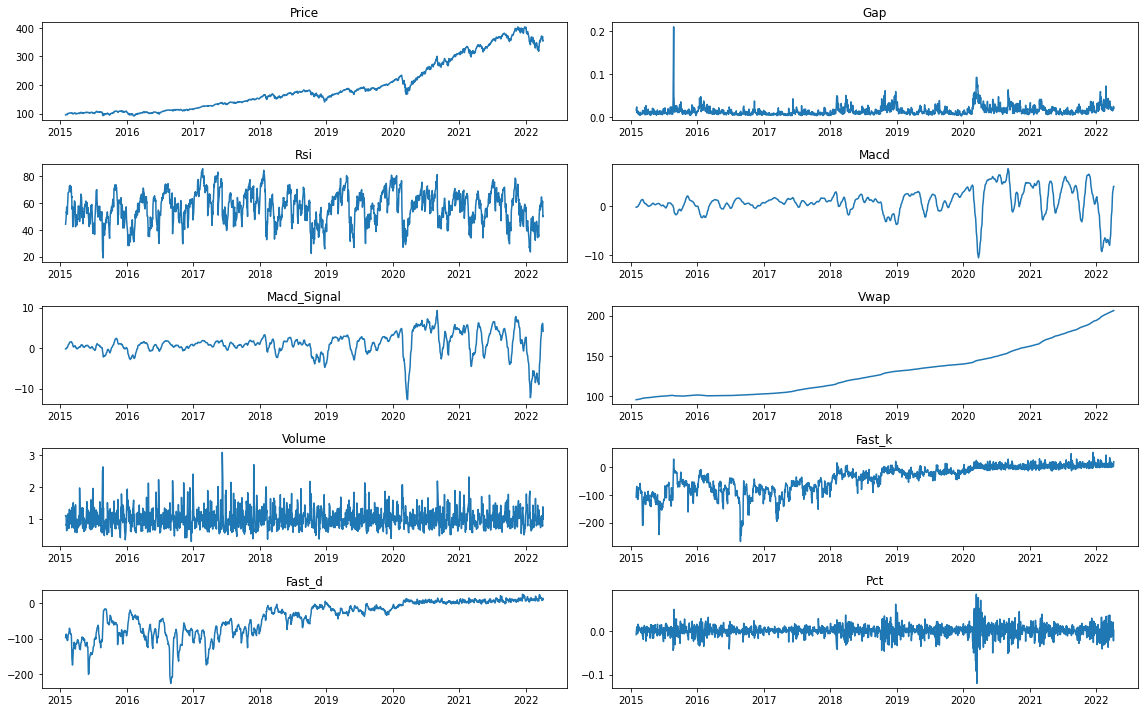

In [8]:
fig, axes = plt.subplots(rows, 2, figsize=(16,10))
for i, c in enumerate(df.columns,start=1):
        plt.subplot(rows, 2, i)
        plt.plot(df[c])
        plt.title(c)
plt.tight_layout()

Volume과 Pct에서 선형성이 사라진 것을 확인 할 수 있다. </br>
이제 모델은 무작정 시간이 지남에 따라 값이 증가한다고 예측하지 못한다.

<AxesSubplot:>

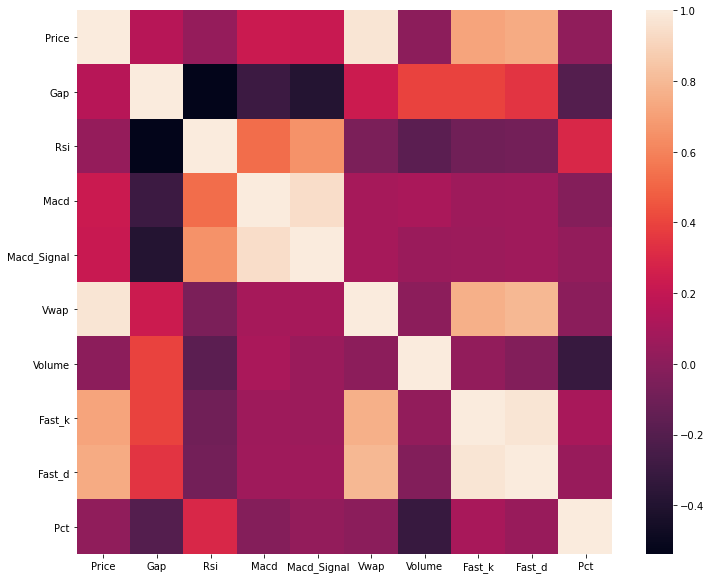

In [9]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr)

In [10]:
corr[corr.abs() > 0.3]

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Pct
Price,1.000000,NaN,NaN,NaN,NaN,0.975672,NaN,0.718436,0.747228,NaN
Gap,NaN,1.000000,-0.537635,NaN,-0.387861,NaN,0.395694,0.394006,0.347346,NaN
Rsi,NaN,-0.537635,1.000000,0.527563,0.656251,NaN,NaN,NaN,NaN,NaN
Macd,NaN,NaN,0.527563,1.000000,0.945765,NaN,NaN,NaN,NaN,NaN
Macd_Signal,NaN,-0.387861,0.656251,0.945765,1.000000,NaN,NaN,NaN,NaN,NaN
Vwap,0.975672,NaN,NaN,NaN,NaN,1.000000,NaN,0.764639,0.795120,NaN
Volume,NaN,0.395694,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,-0.314816
Fast_k,0.718436,0.394006,NaN,NaN,NaN,0.764639,NaN,1.000000,0.974924,NaN
Fast_d,0.747228,0.347346,NaN,NaN,NaN,0.795120,NaN,0.974924,1.000000,NaN
Pct,NaN,NaN,NaN,NaN,NaN,NaN,-0.314816,NaN,NaN,1.000000


pct는 Rsi, Fask_k와 깊은 상관성을 보인다.</br>
price는 vwap와 관련이 깊어 보인다. (자명하지만)

RSI와 가격 증감률 간의 상관 관계를 나타내보면 다음과 같다. </br>
어느 정도의 양의 상관 관계를 갖는 것이 보인다.

In [13]:
def plot_corr(x, y, x_name = 'X_feature', y_name = 'Price_change'):
    plt.figure(figsize=(10,10))
    plt.scatter(x=x, y=y)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

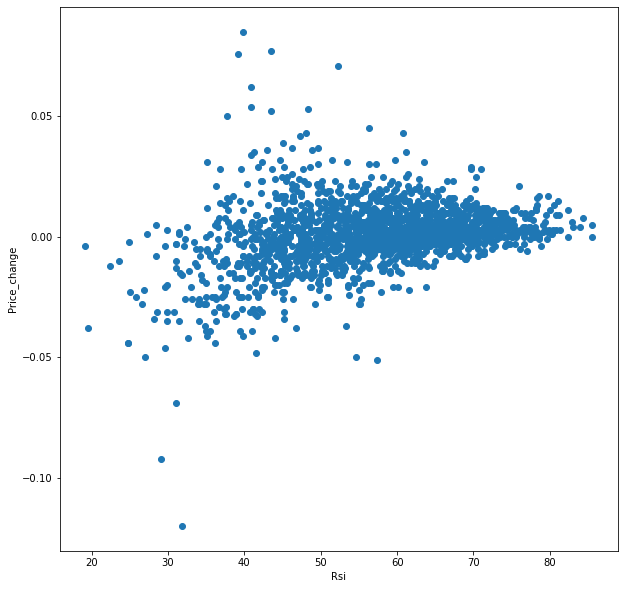

In [14]:
plot_corr(x=df['Rsi'], y=df['Pct'], x_name="Rsi")

#### MACD와 가격 증감률 간의 관계를 살펴보자.

MACD는 이평선의 수렴과 발산을 통해 과매수, 과매도를 보여주는 지표이다. 일반적으로 시그널선의 아래에 위치하면 과매도, 시그널 선의 위편에 위치하면 과매수 상태로 여긴다.


In [16]:
def get_cross(graph1, graph2):
    """ 특정한 그래프 2개를 입력받고 
    그래프가 교차되는 지점을 구해줍니다"""
    gap = graph1 - graph2
    buy_sign = []
    sell_sign = []
    for i, g in enumerate(gap.values[1:], start=1):
        if g * gap[i - 1] < 0:
            if g > 0: #차이가 양으로 전환되면 과매수이므로 매도 시그널이다.
                sell_sign.append(gap.index[i]) 
            else:
                buy_sign.append(gap.index[i])
    return buy_sign, sell_sign

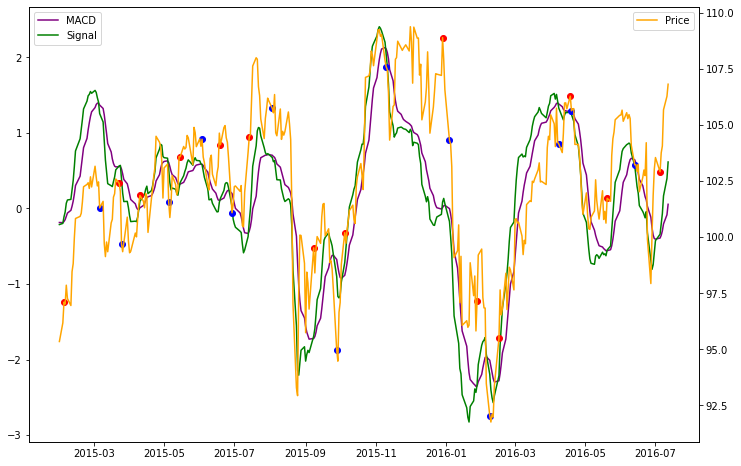

In [17]:
YEAR = 365
fig,ax1 = plt.subplots(figsize=(12,8))
macd_year, signal_year = df['Macd'].iloc[:YEAR], df['Macd_Signal'].iloc[:YEAR]
buy_point, sell_point = get_cross(macd_year, signal_year)
price = df['Price'].iloc[:YEAR]

ax1.plot(macd_year, label='MACD', color='purple')
ax1.plot(signal_year, label='Signal', color='green')
plt.legend(loc="upper left")


ax2 = ax1.twinx()
ax2.plot(price[:365],color='orange',label='Price')
ax2.scatter(buy_point, price.loc[buy_point], marker='o', color='red')
ax2.scatter(sell_point, price.loc[sell_point], marker='o', color='blue')

plt.legend(loc="upper right")

* MACD는 이동평균이라는 정보에 걸맞게 가격의 변동을 원만한 기울기로 추종하고 있다는 것을 확인 할 수 있다. </br>
* Signal과 교차되는 전략을 생각해보면 훌륭하게 들어 맞는다고 볼 수는 없을 것 같다. (빨강: 매수, 파랑: 매도)</br>
하지만 상승, 하락의 신호로 사용하기에는 괜찮은 듯 보인다.


* 피쳐의 관점에선 MACD와 MACD 시그널은 실상 같은 움직임을 보이므로</br>
둘중 하나의 피쳐만 사용하는 쪽이 더 나을 듯 하다. </br>
아니면 시그널과 MACD의 격차만을 피쳐로 사용하는 것도 괜찮아 보인다.

#### 스토캐스틱 지표의 상관관계

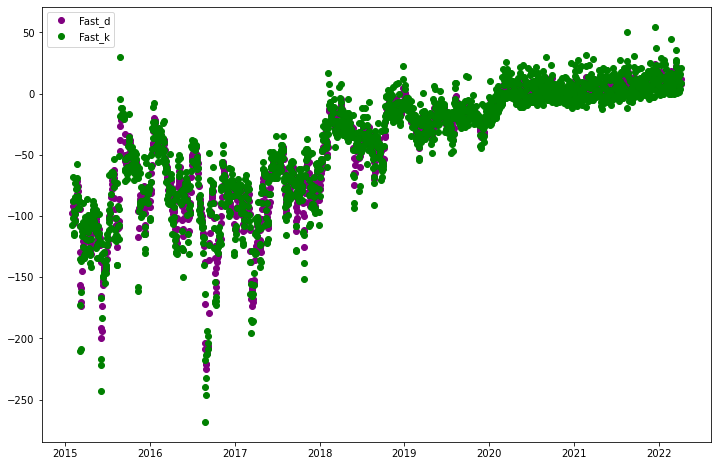

In [18]:
plt.figure(figsize=(12,8))
plt.plot(df['Fast_d'], label='Fast_d', color='purple',linestyle='None',marker='o')
plt.plot(df['Fast_k'], label='Fast_k', color='green',linestyle='None',marker='o')
plt.legend()

Fast_d는 Fast_k를 또 다시 이동평균을 내 활용한 지표이다 보니 값이 전반적으로 안정적이고 극렬하게 튀는 현상이 덜하다.</br>
Fast_k가 가격 증감률과의 상관관계도 더 높지만, 과하게 상태 변화를 받아들이는 값이라는 점에서 </br>
Fast_k보다 Fast_d를 사용하는 쪽이 유리해 보인다.</br>
Fast_k, Fast_d는 상관 계수가 0.7을 넘어가기에 하나만 사용한다.

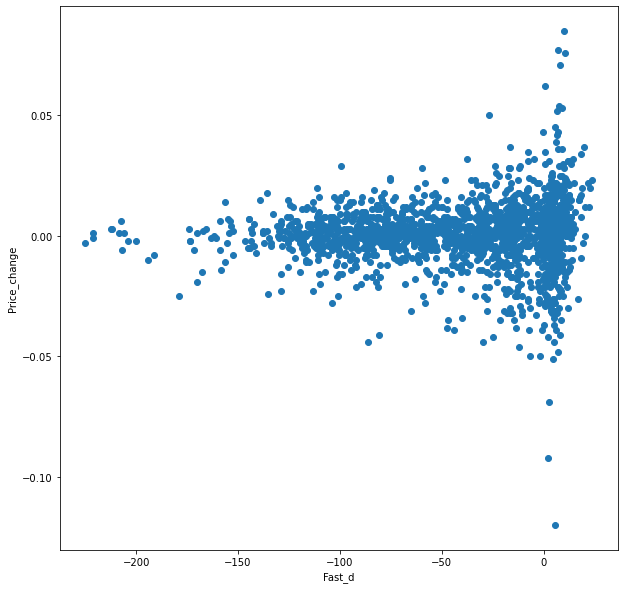

In [19]:
plot_corr(x=df['Fast_d'], y=df['Pct'],x_name="Fast_d")

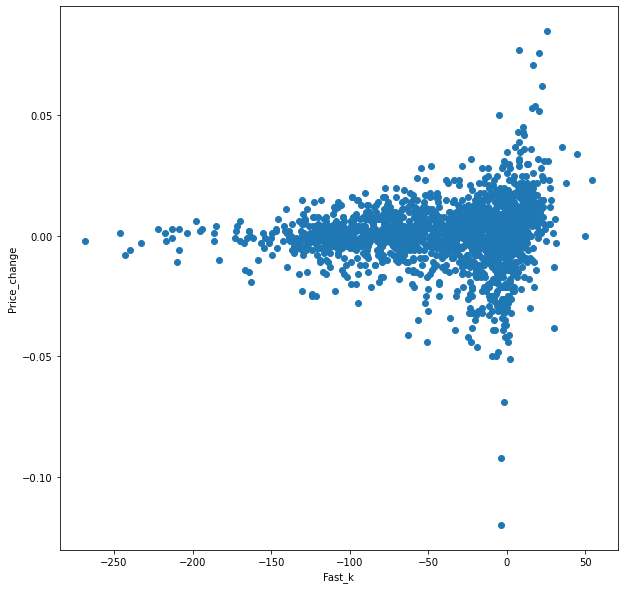

In [20]:
plot_corr(x=df['Fast_k'],y=df['Pct'],x_name="Fast_k")

#### 피쳐 선택
다음과 같은 피쳐를 제외하고 모델을 학습 시키기로 했다.
* Price: 대신 가격 증감률을 사용하기로 했다.
* Macd, Macd_Signal: 대신 시그널 - MACD를 사용한다.
* Fast_k: 대신 Fast_d를 사용한다.

In [25]:
macd_gap = df['Macd_Signal'] - df['Macd']
new_df = df.drop(["Macd", "Fast_k", "Price"], axis=1)
new_df["Macd_Gap"] = macd_gap
new_df

,Gap,Rsi,Macd_Signal,Vwap,Volume,Fast_d,Pct,Macd_Gap
time,,,,,,,,
2015-01-30,0.016,44.179,-0.214,95.965,1.097,-97.350,-0.008,-0.027
2015-02-02,0.023,48.785,-0.199,95.975,1.104,-87.702,0.009,-0.010
2015-02-03,0.013,53.396,-0.112,96.013,0.789,-87.693,0.010,0.062
2015-02-04,0.012,52.925,-0.049,96.049,0.832,-92.252,-0.001,0.100
2015-02-05,0.009,56.970,0.068,96.092,0.623,-93.508,0.009,0.173
...,...,...,...,...,...,...,...,...
2022-04-01,0.014,57.198,5.561,205.659,0.895,6.443,-0.002,2.767
2022-04-04,0.019,61.367,6.085,205.767,0.768,9.561,0.021,2.633
2022-04-05,0.024,55.015,5.772,205.907,1.036,7.495,-0.022,1.856


#### 이상치 확인 해보기
* iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. 
* gap, vwap, macd가 특히 심하다.


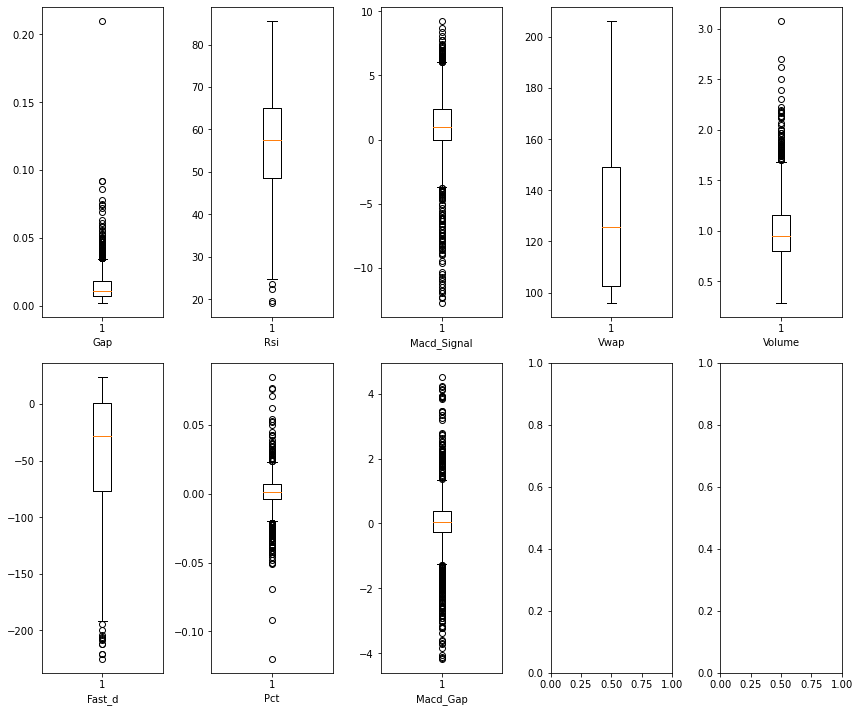

In [26]:
fig,axes = plt.subplots(2,5,figsize=(12,10))
for i, c in enumerate(new_df.columns,start=1):
    plt.subplot(2,5,i)
    plt.boxplot(new_df[c])
    plt.xlabel(c)
plt.tight_layout()

In [27]:
from collections import defaultdict
def get_outliers(df):
    """ 
        iqr 범위를 벗어나는 아웃 라이어들의 인덱스를 반환한다.
    """
    q_1 = df.apply(lambda x: np.quantile(x, 0.25))
    q_3 = df.apply(lambda x: np.quantile(x, 0.75))
    iqr = q_3 - q_1
    min_p = q_1 - 1.5 * iqr
    max_p = q_3 + 1.5 * iqr
    outliers = np.where((df < min_p) | (df > max_p))
    row, col = outliers
    outliers_loc = defaultdict(list)
    for r,c in zip(row,col):
        outliers_loc[df.columns[c]].append(r)
    return outliers_loc


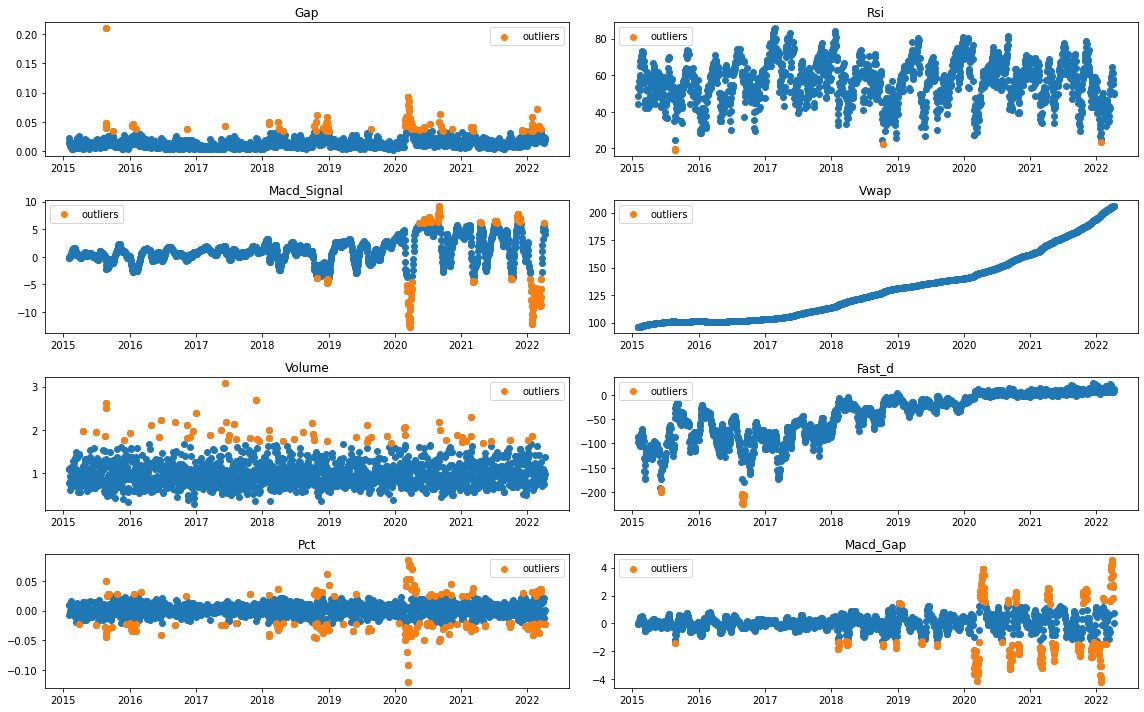

In [28]:
def draw_outlier(outliers_cols, df):
    """ 아웃 라이어들을 피쳐 별로 전부 그려 줍니다"""
    rows = get_rows(len(df.columns))
    fig, axes = plt.subplots(rows, 2, figsize=(16,10))
    for i, c in enumerate(df.columns,start=1):
        index = df[c].index
        plt.subplot(rows,2,i)
        plt.title(c)
        plt.scatter(x=index,y=df[c])
        plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
        plt.legend()
    plt.tight_layout()

outliers_cols = get_outliers(new_df)
draw_outlier(outliers_cols, new_df)

피쳐별로 아웃라이어를 모조리 제거해 주기에는 문제가 있다. </br>
RSI에서 잡힌 아웃라이어 정도만 제거해준다.

In [29]:
for k, v in outliers_cols.items():
    print(f"{k}: {len(v)}")

Pct: 159
Volume: 62
Fast_d: 12
Gap: 84
Rsi: 4
Macd_Gap: 199
Macd_Signal: 128
Vwap: 0


In [30]:
def get_profit(X):
    """수익률을 구해준다."""
    seed = [1]
    for i, v in enumerate(X[1:], start=1):
        seed.append(seed[i - 1] * (1 + v))
    return seed

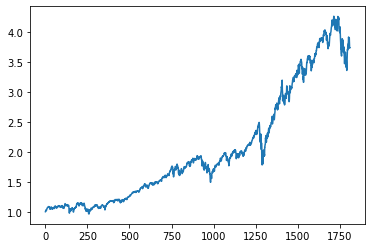

In [31]:
#수익 곡선을 그려보자 비트코인 그래프와 흡사하게 그려진다.
plt.plot(get_profit(new_df['Pct']))

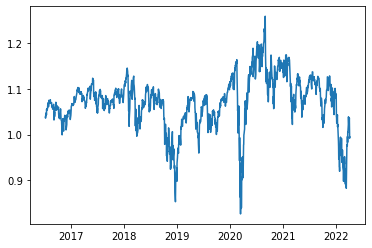

In [33]:
#모멘텀 팩터 만들기
profit = pd.Series(index=new_df.index, data=get_profit(new_df['Pct'])) #profit은 실제 내 수익률을 보여준다.
m2 = profit / profit.rolling(60).mean() #1달 간의 평균 수익률
m6 = profit / profit.rolling(180).mean() #2달 간의 평균 수익률
y1 = profit / profit.rolling(365).mean() #2주 간의 평균 수익률
momentum = (m2 * 0.5 + m6 * 0.3 + y1 * 0.2).dropna()
plt.plot(momentum)

In [35]:
momentum.index = new_df.index[364:] #모멘텀 지표를 df에 추가해준다.
momentum.name = "Moment"
moment_df = new_df.join(momentum).dropna()
moment_df

,Gap,Rsi,Macd_Signal,Vwap,Volume,Fast_d,Pct,Macd_Gap,Moment
time,,,,,,,,,
2016-07-12,0.004,63.341,0.614,101.158,0.980,-46.212,0.005,0.560,1.038323
2016-07-13,0.005,62.029,0.758,101.167,0.938,-46.224,-0.002,0.563,1.036146
2016-07-14,0.004,64.273,0.920,101.177,0.929,-44.925,0.007,0.580,1.043172
2016-07-15,0.007,63.318,1.022,101.186,0.836,-43.983,-0.002,0.546,1.040900
2016-07-18,0.008,65.581,1.148,101.196,0.952,-43.561,0.007,0.537,1.047933
...,...,...,...,...,...,...,...,...,...
2022-04-01,0.014,57.198,5.561,205.659,0.895,6.443,-0.002,2.767,1.014979
2022-04-04,0.019,61.367,6.085,205.767,0.768,9.561,0.021,2.633,1.036439
2022-04-05,0.024,55.015,5.772,205.907,1.036,7.495,-0.022,1.856,1.013941


모멘텀을 연산했다.

<AxesSubplot:>

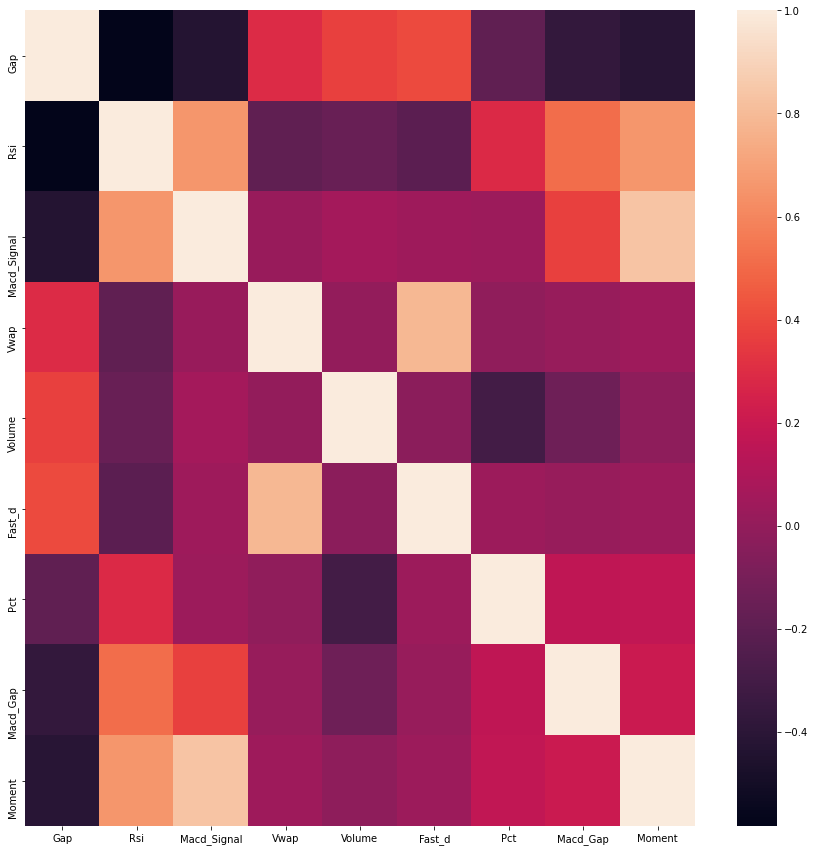

In [36]:
corr = moment_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr)

모멘트 팩터는 RSI, MACD 등 다른 모멘텀과 연관된 피쳐와 깊은 상관 관계를 보인다.

모델을 생성하고 비교해보자.

In [51]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=3, include_bias=False)),
    ('min_max',MinMaxScaler()),
    ('regulator', Ridge(alpha=10,solver="sag",random_state=42,fit_intercept=True))
])

lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=3, include_bias=True)),
    ('min_max',MinMaxScaler()),
    ('regulator', Lasso(alpha=10,random_state=42,fit_intercept=True))
])

from sklearn.linear_model import LinearRegression
linear_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=3, include_bias=True)),
    ('min_max',MinMaxScaler()),
    ('model', LinearRegression(fit_intercept=True))
])

rf_model = Pipeline([
    ('min_max',MinMaxScaler()),
    ('model',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True, max_depth=200))
])

In [38]:
def create_train_data(df):
    """ 트레이닝 데이터를 생성한다. 
        다음날 데이터를 예측 해야 하므로 한 칸씩 미뤄주고 댕겨준다.
    """
    X = df.drop(['Pct'], axis=1).iloc[1:]
    y = df['Pct'].iloc[:-1]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    return train_X, test_X, train_y, test_y

In [52]:
train_X, test_X, train_y, test_y = create_train_data(moment_df)
ridge_model.fit(train_X, train_y)
lasso_model.fit(train_X, train_y)
linear_model.fit(train_X, train_y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('min_max', MinMaxScaler()), ('model', LinearRegression())])

In [40]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    """파라미터 값을 변경해가며 알파 값을 바꿔본다."""
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)



mse: 0.00018200404609901554, alpha: 1000
mse: 0.00017787246281518693, alpha: 300
mse: 0.00017645673676156096, alpha: 100
mse: 0.00017622573203512145, alpha: 30
mse: 0.00017630229024450034, alpha: 10
mse: 0.00018002441483918604, alpha: 1
mse: 0.00018977128686108587, alpha: 1000
mse: 0.00018977128686108587, alpha: 300
mse: 0.00018977128686108587, alpha: 100
mse: 0.00018977128686108587, alpha: 30
mse: 0.00018977128686108587, alpha: 10
mse: 0.00018977128686108587, alpha: 1


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('min_max', MinMaxScaler()),
                ('regulator', Lasso(alpha=1000, random_state=42))])

In [41]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse*100:.3f}')
    plt.legend()

In [53]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)
lin_pred = linear_model.predict(test_X)

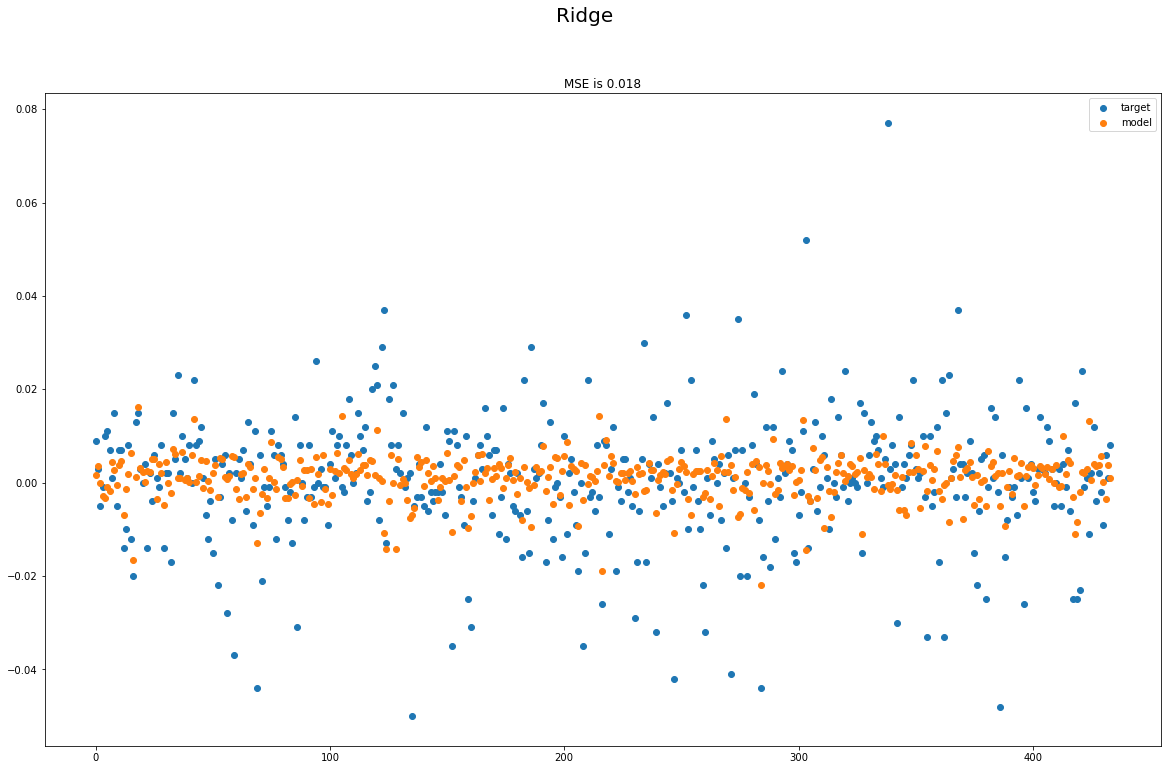

In [43]:
visualize(r_pred,test_y,"Ridge")

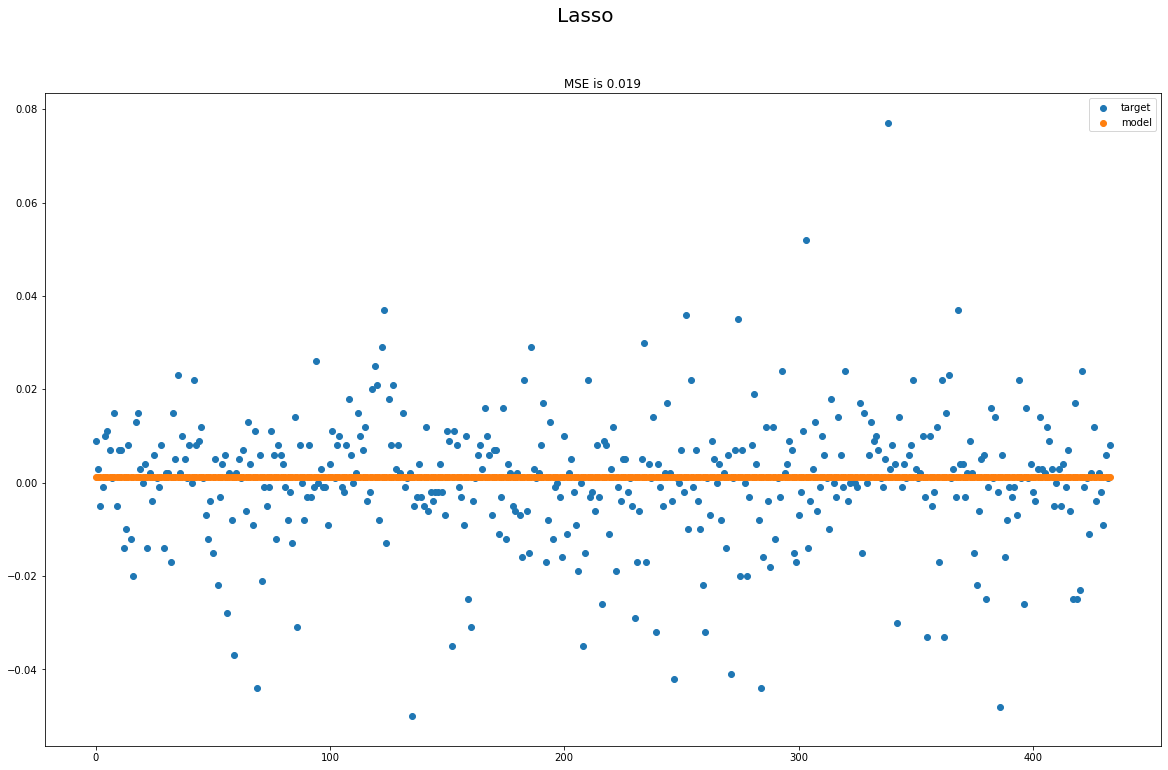

In [44]:
visualize(l_pred, test_y, "Lasso")

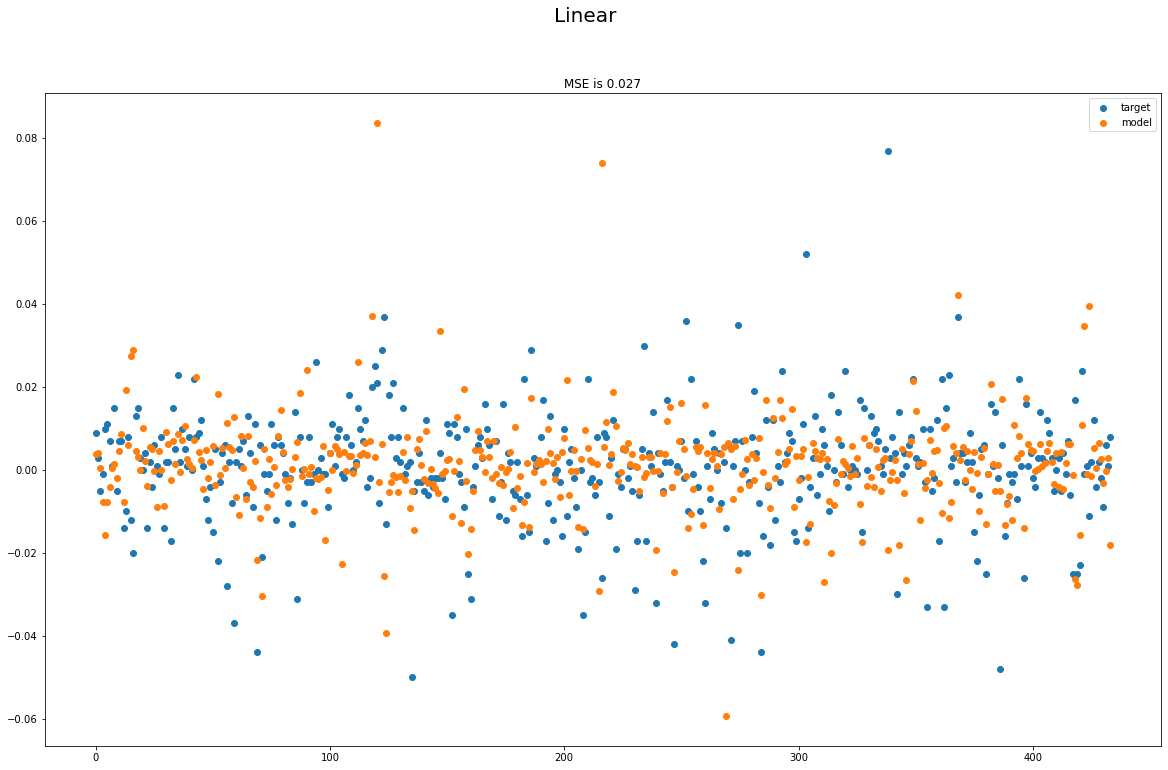

In [54]:
visualize(lin_pred, test_y, "Linear")

In [45]:
def visualize_plot(pred, target, name):
    """ 예측한 증감률과 실제 증감률을 활용해 수익 곡선을 그려준다."""
    target_profit = get_profit(target)
    pred_profit = get_profit(pred)
    plt.figure(figsize=(12,10))
    plt.plot(target_profit, label='target')
    plt.plot(pred_profit, label='pred')
    plt.title(name)
    plt.legend()

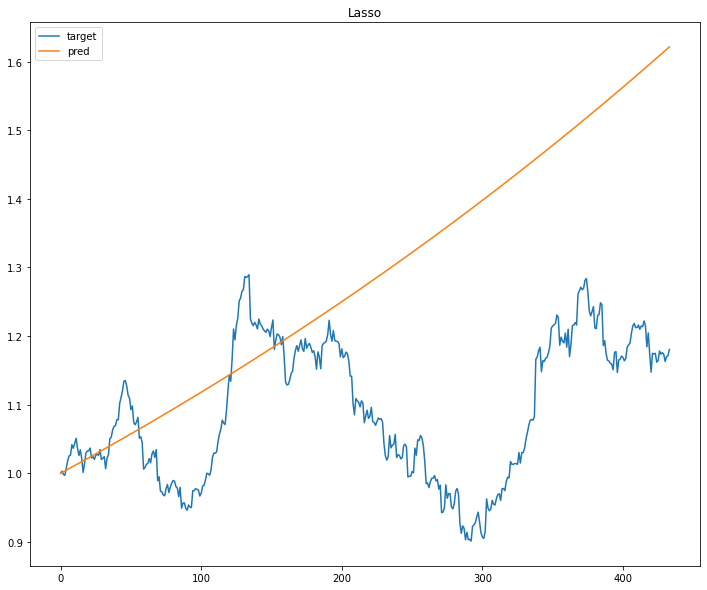

In [46]:
visualize_plot(l_pred, test_y, "Lasso")

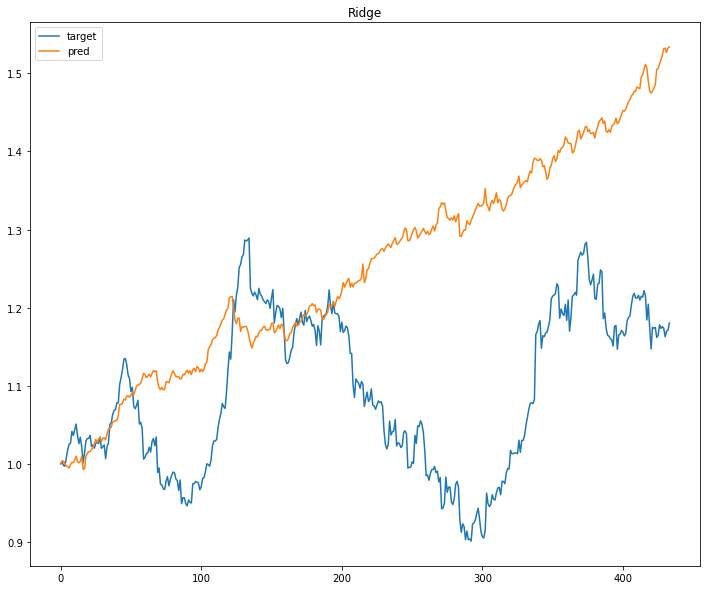

In [47]:
visualize_plot(r_pred, test_y, "Ridge")

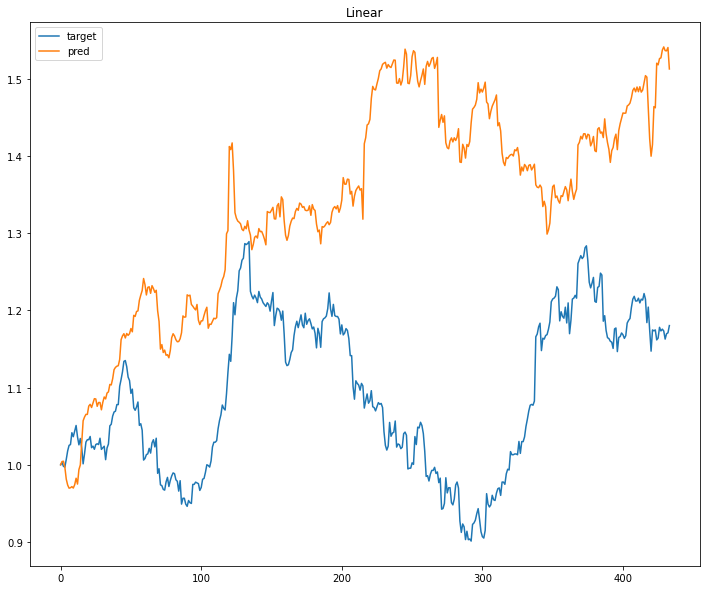

In [55]:
visualize_plot(lin_pred, test_y, "Linear")

In [48]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

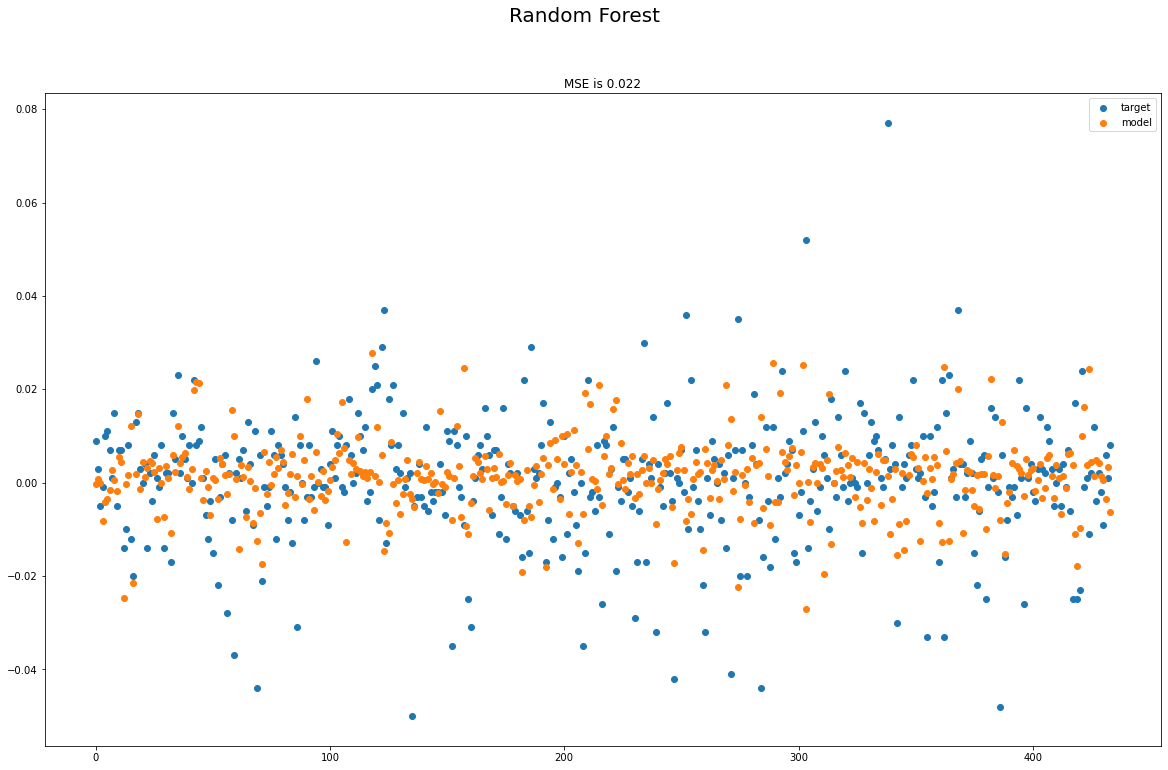

In [49]:
visualize(rf_pred, test_y, "Random Forest")

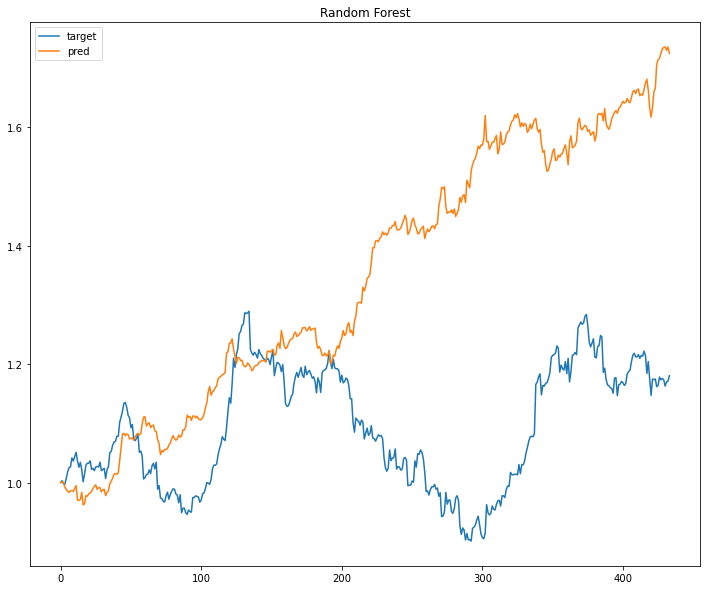

In [50]:
visualize_plot(rf_pred, test_y, "Random Forest")